In [43]:
import geopandas as gpd  

# 文件路径  
file_path = r'C:\Users\19947\MY PYTHON code\311\ZIPCODE\ZIP_CODE_040114.shp'  

# 读取 Shapefile  
gdf = gpd.read_file(file_path)  

# 显示前几行  
print(gdf.head())

  ZIPCODE BLDGZIP   PO_NAME  POPULATION          AREA STATE  COUNTY ST_FIPS  \
0   11436       0   Jamaica     18681.0  2.269930e+07    NY  Queens      36   
1   11213       0  Brooklyn     62426.0  2.963100e+07    NY   Kings      36   
2   11212       0  Brooklyn     83866.0  4.197210e+07    NY   Kings      36   
3   11225       0  Brooklyn     56527.0  2.369863e+07    NY   Kings      36   
4   11218       0  Brooklyn     72280.0  3.686880e+07    NY   Kings      36   

  CTY_FIPS                   URL  SHAPE_AREA  SHAPE_LEN  \
0      081  http://www.usps.com/         0.0        0.0   
1      047  http://www.usps.com/         0.0        0.0   
2      047  http://www.usps.com/         0.0        0.0   
3      047  http://www.usps.com/         0.0        0.0   
4      047  http://www.usps.com/         0.0        0.0   

                                            geometry  
0  POLYGON ((1038098.252 188138.38, 1038141.936 1...  
1  POLYGON ((1001613.713 186926.44, 1002314.243 1...  
2  PO

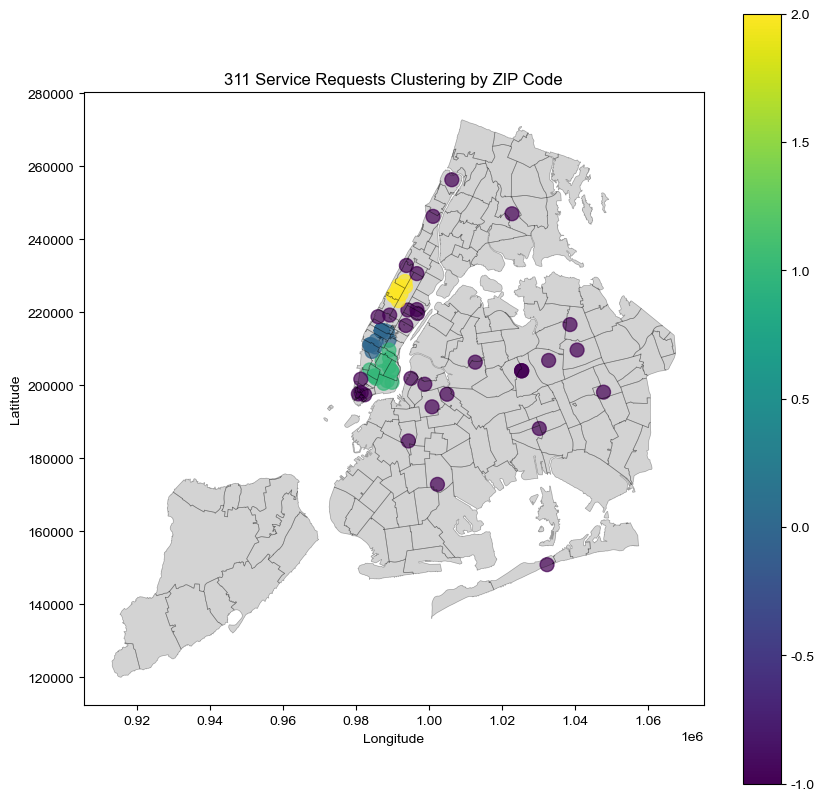

In [55]:
import geopandas as gpd  
import pandas as pd  
import matplotlib.pyplot as plt  
from shapely.geometry import Point  
from sklearn.cluster import DBSCAN  

# 加载邮政编码 shapefile  
zip_codes = gpd.read_file(r'C:\Users\19947\MY PYTHON code\311\ZIPCODE\ZIP_CODE_040114.shp')  

# 加载服务请求 CSV 文件  
service_requests = pd.read_csv(r"C:\Users\19947\MY PYTHON code\311\311_Service_Requests_from_2010_to_Present_20241207.csv")  

# 创建 GeoDataFrame  
geometry = [Point(xy) for xy in zip(service_requests['Longitude'], service_requests['Latitude'])]  
gdf_requests = gpd.GeoDataFrame(service_requests, geometry=geometry)  
gdf_requests.crs = "EPSG:4326"  # WGS84坐标系  

# 转换坐标系并进行空间连接  
gdf_requests = gdf_requests.set_crs("EPSG:4326").to_crs(zip_codes.crs)  
merged = gpd.sjoin(gdf_requests, zip_codes, how="inner", predicate='intersects')  

# 埃普森聚类  
coords = merged[['Longitude', 'Latitude']].values  
db = DBSCAN(eps=0.01, min_samples=5).fit(coords)  
merged['Cluster'] = db.labels_  

# 可视化结果  
fig, ax = plt.subplots(figsize=(10, 10))  
# 绘制邮政编码边界，使用浅色填充  
zip_codes.boundary.plot(ax=ax, linewidth=0.5, color='k', alpha=0.3)  # 设置边界透明度  
zip_codes.plot(ax=ax, color='lightgrey')  # 设置邮政编码区域颜色  

# 增大散点尺寸并绘制聚类结果  
merged.plot(column='Cluster', ax=ax, legend=True, cmap='viridis', markersize=100, alpha=0.7)  

plt.title('311 Service Requests Clustering by ZIP Code')  
plt.xlabel('Longitude')  
plt.ylabel('Latitude')  
plt.show()

In [63]:
# 计算每个邮政编码区域的请求数量  
requests_count = merged.groupby('ZIPCODE').size().reset_index(name='Request Count')  

# 打印请求数量，以便观察  
print("请求数量分布：")  
print(requests_count)  

# 过滤出比较密集的区域  
threshold = 3  # 降低阈值  
dense_areas = requests_count[requests_count['Request Count'] > threshold]  

# 打印比较密集的区域  
print("密集区域：")  
print(dense_areas)  


请求数量分布：
   ZIPCODE  Request Count
0    10001              1
1    10002              3
2    10003              2
3    10006              1
4    10007              1
5    10009              3
6    10010              1
7    10011              5
8    10012              4
9    10013              1
10   10016              2
11   10019              1
12   10021              2
13   10022              1
14   10023              2
15   10024              5
16   10025              3
17   10026              1
18   10032              1
19   10034              1
20   10036             48
21   10038              1
22   10075              1
23   10462              1
24   11203              1
25   11206              1
26   11211              1
27   11237              1
28   11238              1
29   11249              1
30   11358              1
31   11365              1
32   11367              1
33   11375              3
34   11378              1
35   11417              1
36   11423              1
37  

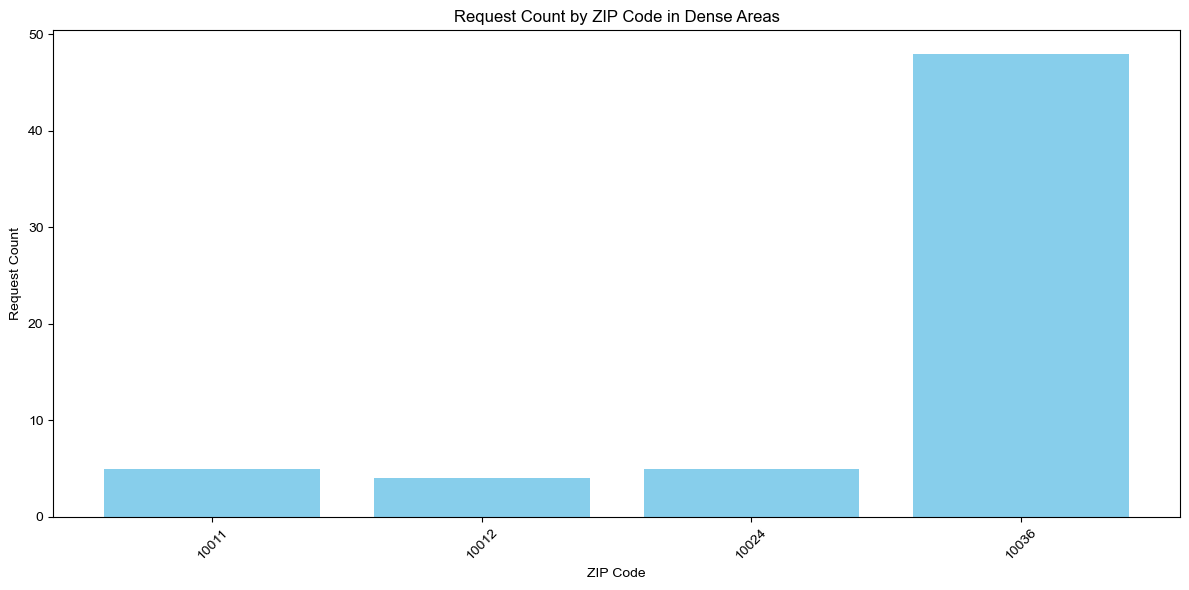

In [65]:
# 绘制条形图  
plt.figure(figsize=(12, 6))  
plt.bar(dense_areas['ZIPCODE'].astype(str), dense_areas['Request Count'], color='skyblue')  
plt.title('Request Count by ZIP Code in Dense Areas')  
plt.xlabel('ZIP Code')  
plt.ylabel('Request Count')  
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()  

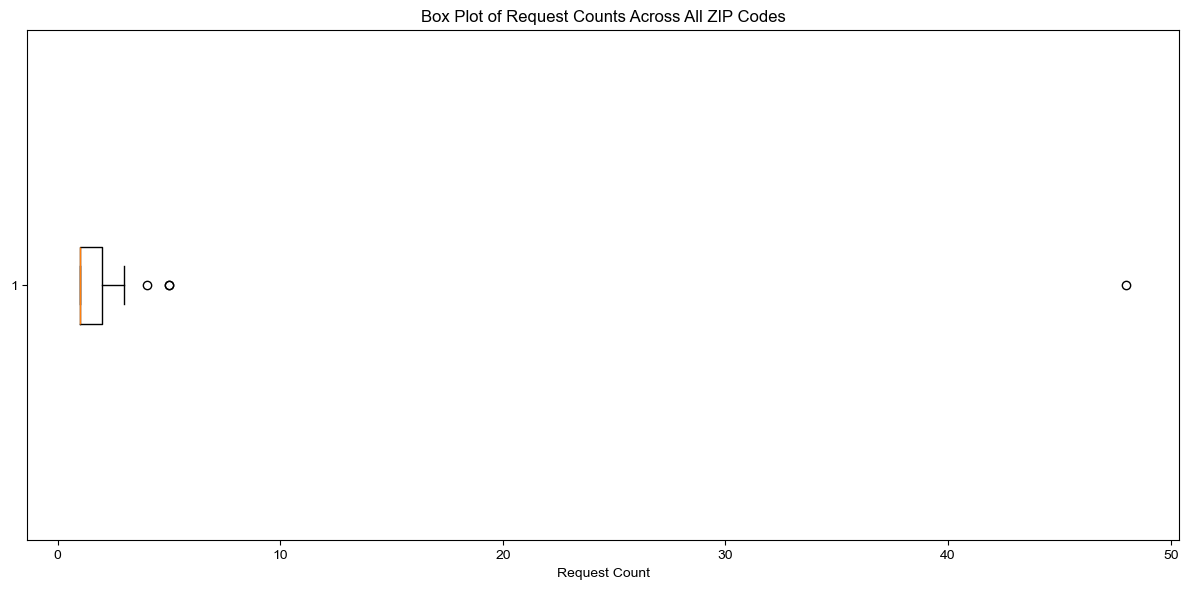

In [67]:
# 为所有区域绘制箱型图  
plt.figure(figsize=(12, 6))  
plt.boxplot(requests_count['Request Count'], vert=False)  
plt.title('Box Plot of Request Counts Across All ZIP Codes')  
plt.xlabel('Request Count')  
plt.tight_layout()  
plt.show()